This notebook shows an example of how to predict joint distributions, for example the color-stellar mass diagram $P(M_*, g - i)$, of three central galaxies given the host halo properties (from the 'example.csv' file).

# Settings

Choose the properties $X_1$ and $X_2$ to predict the joint distribution $P(X_1, X_2)$:

*   $M_*$ = 'smass'
*   $g - i$ = 'color'
*   sSFR = 'sSFR'
*   $R^{(*)}_{1/2}$ = 'radius'



In [2]:
# Choose galaxy properties to predict

x_name = 'smass'  # x-axis property, X1
y_name = 'color'  # y-axis property, X2


prop_name = y_name + '_' + x_name
nbin = 50

# Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from keras.models import load_model
from keras.utils import np_utils

# Load data set

In [4]:
df = pd.read_csv('example.csv')

# Get halo input properties from the loaded data set
input_vec = ['M_h', 'C_h', 'S_h', 'z_h', 'Delta3_h']

x_df = df[input_vec].to_numpy()

# Functions

In [5]:
def plot_joint(map,
               tick_x, tick_y,
               label_x, label_y):
  """
  Plot joint distributions.

  :param map: joint target
  :type map: numpy.array

  """

  nticks = int(nbin/4)
  hist_color = 'lightgray'


  fig = plt.figure(figsize=(10, 10))

  gs = GridSpec(4,4)

  ax_joint = fig.add_subplot(gs[1:4,0:3])
  ax_marg_x = fig.add_subplot(gs[0,0:3])
  ax_marg_y = fig.add_subplot(gs[1:4,3])

  cp=ax_joint.imshow(np.log10(map + 1), origin='low', cmap='jet', aspect="auto")
  #cbar = plt.colorbar(cp)

  ax_marg_x.plot(np.sum(map, axis=0), linewidth=2, color='k', label='Predicted')
  ax_marg_y.plot(np.sum(map, axis=1), np.arange(np.sum(map, axis=1).shape[0]), linewidth=2, color='k')
  ax_marg_x.legend(fontsize=16)

  # Turn off tick labels on marginals
  plt.setp(ax_marg_x.get_xticklabels(), visible=False)
  plt.setp(ax_marg_y.get_yticklabels(), visible=False)

  # Set labels on joint
  ax_joint.set_xlabel(label_x, fontsize=28)
  ax_joint.set_ylabel(label_y, fontsize=28)

  ax_marg_x.set_xticks(np.arange(0, len(tick_x))[0::nticks])
  ax_marg_x.set_xticks(np.arange(0, len(tick_y))[0::nticks])
  ax_marg_y.set_yticklabels([])
  ax_marg_x.set_xlim(0, 49)
  ax_marg_y.set_ylim(0, 49)

  ax_marg_x.tick_params(labelsize=20)
  ax_marg_y.tick_params(labelsize=20)
  ax_joint.tick_params(labelsize=26)

  ax_joint.set_xticks(np.arange(0, len(tick_x))[0::nticks])
  ax_joint.set_xticklabels(np.round(tick_x, 2)[0::nticks], fontsize=24)

  ax_joint.set_yticks(np.arange(0, len(tick_y))[0::nticks][1:])
  ax_joint.set_yticklabels(np.round(tick_y, 2)[0::nticks][1:], fontsize=24)

  ax_joint.set_xlim(0)
  ax_joint.set_ylim(0)

  plt.show()


def sample_2D(probs):
  """
  Sample galaxies according to joint distribution P(x, y) (2D).
  A galaxy is a pair of properties (x, y).

  :param probs: probabilities
  :type probs: numpy.array; shape = (nbin x nbin)

  :return: (x, y) coordinates in the target map for the galaxy in probs
  :rtype: numpy.array, numpy.array
  """

  # Bin indices
  vec = np.arange(0, int(nbin**2), 1)

  # Pick the galaxy's PDF
  probs_round = np.round(probs * 1000)

  # List with bin indices. The PDF dictates the number of times each bin appears.
  bin_to_sample = np.repeat(vec, probs_round.astype(int))

  # Now we draw a number from the above list. The number correspond to the bin index.
  choice = np.random.choice(bin_to_sample)

  # Back: identify the bin in the grid nbin x nbin
  choice_m = np_utils.to_categorical(choice, num_classes=int(nbin**2))
  choice_m = choice_m.reshape(nbin, nbin)

  # Identify y and x corresponding to the bin
  y_sampled, x_sampled = np.where(choice_m != 0)

  return y_sampled, x_sampled



def discretize_inverse(prop_values, prop_name):
  """
  Associate galaxy property value to bin index (class).

  :param prop_values: bin indices (classes) to be converted into continuous value
  :type prop_values: numpy.array
  :param prop_name: 'smass', 'color', 'sSFR' or 'radius'
  :type prop_name: str

  :return: values of the properties for each data set element
  :rtype: numpy.array
  """
  edges = pd.read_csv('bin_edges.csv'.format(nbin))[prop_name].to_numpy()
  means = pd.read_csv('bin_means.csv'.format(nbin))[prop_name].to_numpy()

  values_prop = []

  for v in prop_values:
    values_prop.append(means[v])

  return np.array(values_prop)



"""
Discretize properties: convert contunuous values into classes.

:param v: values to be binned
:type v: numpy.array

:return: binned values
:rtype: numpy.array
"""

def discretize_smass(v):
  
  vec = v.copy()

  hist = np.histogram(vec, bins=nbin, range=(8.75, 13.))[1]

  for i in range(len(hist) - 1):
    vec[(v > hist[i]) & (v <= hist[i + 1])] = i

  return vec


def discretize_color(v):
  
  vec = v.copy()

  hist = np.histogram(vec, bins=nbin, range=(-0.3, 1.22))[1]

  for i in range(len(hist) - 1):
    vec[(v > hist[i]) & (v <= hist[i + 1])] = i

  return vec


def discretize_sSFR(v):
  
  vec = v.copy()

  hist = np.histogram(vec, bins=nbin, range=(-17, -8.3))[1]

  for i in range(len(hist) - 1):
    vec[(v > hist[i]) & (v <= hist[i + 1])] = i

  return vec


def discretize_radius(v):
  
  vec = v.copy()

  hist = np.histogram(vec, bins=nbin, range=(0.05, 2.2))[1]

  for i in range(len(hist) - 1):
    vec[(v > hist[i]) & (v <= hist[i + 1])] = i

  return vec


discretize_dict = {'smass':discretize_smass,
                   'color':discretize_color,
                   'sSFR':discretize_sSFR,
                   'radius':discretize_radius}


label_dict = {'smass':'$\log_{10}(M_* [h^{-1}M_\odot])$',
              'color':'$g - i$',
              'sSFR':'$\log_{10}($sSFR $[yr^{-1}h])$',
              'radius':'$\log_{10}(R^{(*)}_{1/2} [h^{-1}$kpc])',
              'hmass':'$\log_{10}(M_{vir} [h^{-1}M_\odot])$'}

tick_dict = pd.read_csv('bin_edges.csv')

# Apply model

1/1 [==============================] - 0s 183ms/step


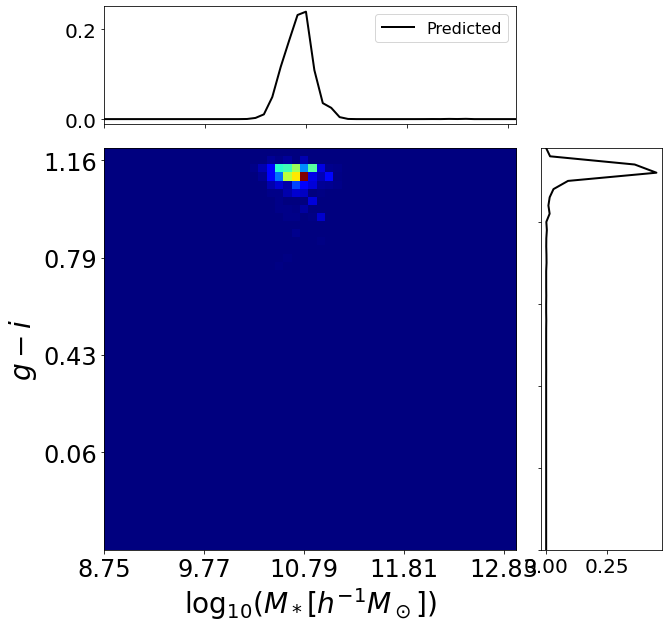


Sampled values:
   color    smass
0  1.144  10.9175





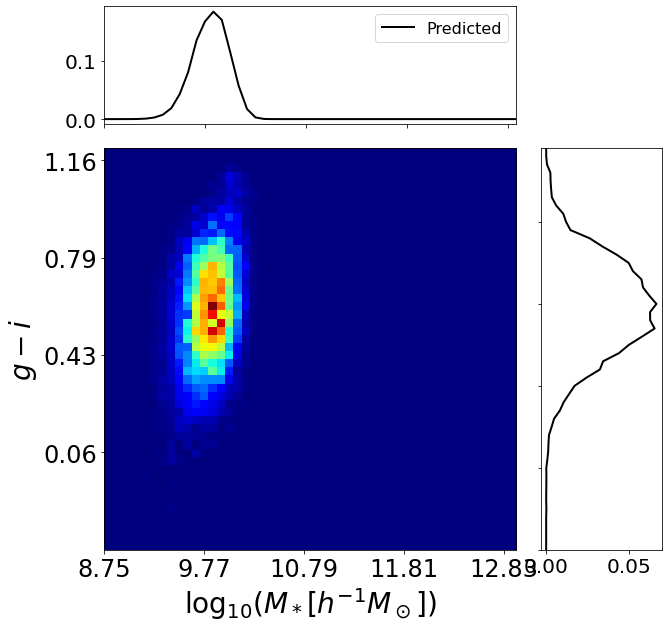


Sampled values:
    color   smass
0  0.7792  9.8975





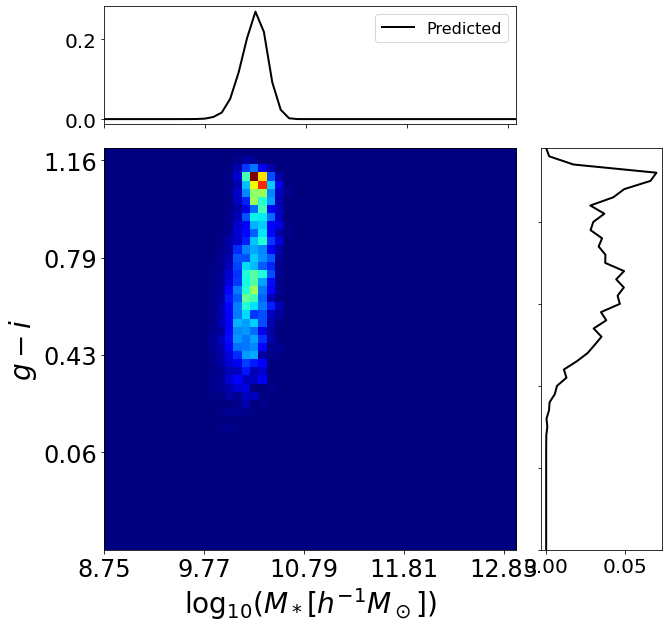


Sampled values:
    color    smass
0  1.1136  10.1525





In [6]:
# Load model
model = load_model('models/{}_model.h5'.format(prop_name))

# Run model
pred_list = model.predict(x_df)


for pred in pred_list:

  # Plot predicted diagram
  
  map = pred.reshape(nbin, nbin)

  discretize_x = discretize_dict[x_name]
  discretize_y = discretize_dict[y_name]

  sample_dict = {'tick_x': tick_dict[x_name], 'tick_y': tick_dict[y_name],
                 'label_x': label_dict[x_name], 'label_y': label_dict[y_name]}

  plot_joint(map, **sample_dict)


  # Sample values from the predicted distribution to generate a catalog
  # of galaxy properties.

  y_values, x_values = sample_2D(pred)

  # Assign value to the sampled coordinates
  y_values_prop = discretize_inverse(y_values, y_name)
  x_values_prop = discretize_inverse(x_values, x_name)

  # Save values to csv
  table = pd.concat([pd.DataFrame(y_values_prop),
                      pd.DataFrame(x_values_prop)], axis=1)

  table.columns = [y_name, x_name]

  print('\nSampled values:')
  print(table.head())
  print('\n\n')